In [240]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from feat_desc import *
import cv2
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%.3g" % x))
from corner_detector import *
from anms import *
from feat_match import *
from ransac_est_homography import *

max_anms=3000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
# img1=cv2.imread('small-right.jpg')
# img1=cv2.imread('small-middle.jpg')
img1=cv2.imread('mountain1.jpg')
# img1=cv2.imread('case1.png')
# img1=cv2.imread('rot-middle.jpg')
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
c = corner_detector(gray)
print(np.sum(c>0))
X1,Y1,rmax=anms(c, max_anms)
d1 = feat_desc(gray,X1,Y1)
kp1=[]
for (_x,_y) in zip(X1,Y1):
    kp1.append(cv2.KeyPoint(_x,_y,40))


7574


In [243]:
# img2=cv2.imread('small-right.jpg')
img2=cv2.imread('mountain2.jpg')
# img2=cv2.imread('small-right.jpg')
# img2=cv2.imread('case2.png')
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
c = corner_detector(gray)
print(np.sum(c>0))
X2,Y2,rmax=anms(c, max_anms)
d2 = feat_desc(gray,X2,Y2)
print("Rmax" + str(rmax))
kp2=[]
for (_x,_y) in zip(X2,Y2):
    kp2.append(cv2.KeyPoint(_x,_y,40))


8095
Rmax3.0


In [244]:
m,dMatch=feat_match(d1, d2)
x1=[]
y1=[]
x2=[]
y2=[]

for k,idx in enumerate(m):
    if (idx != -1):
        # is 0 x or 1 x?
        x1.append(X1[idx])
        y1.append(Y1[idx])
        x2.append(X2[k])
        y2.append(Y2[k])
x1=np.array(x1)
x2=np.array(x2)
y1=np.array(y1)
y2=np.array(y2)
# print(X1.shape)

In [245]:
f=np.vstack((x1,y1))
points1 = f.T
g=np.vstack((x2,y2))
points2 = g.T
H, mask = cv2.findHomography(points1, points2,cv2.RANSAC)
print(H)

[[1.01 -2.3 315]
 [0.168 0.0398 33.4]
 [0.00173 -0.0053 1]]


254
36223.45306593105
32618.753828103247
29990.941076065414
27005.610661996616
26971.319042123687
26757.37441883156
26737.690094045025
26597.959042079514
26549.43165649363
26405.4318518359
26381.47927972029
26169.5824166453
MaxInlierCount4
[[-0.746 0.267 241]
 [-0.422 0.153 136]
 [-0.0031 0.00113 1]]


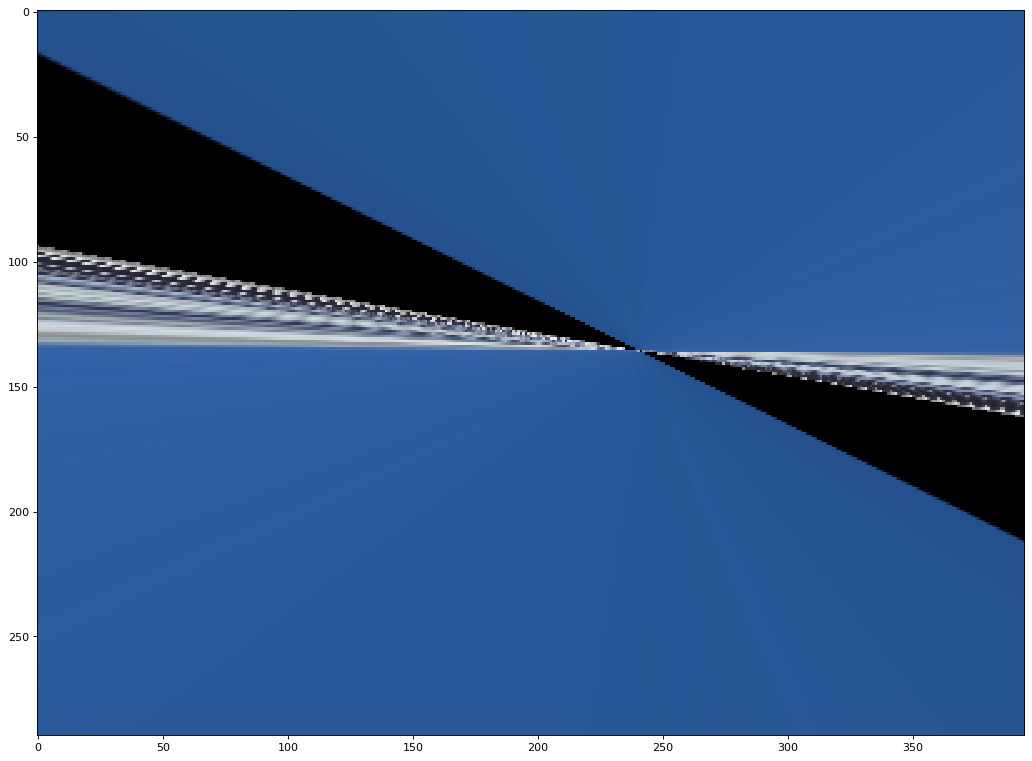

In [246]:
print(len(x1))
H, inlier_ind=ransac_est_homography(x1,y1,x2,y2,0.005)

result = cv2.warpPerspective(img1, H,(int(img1.shape[1]), int(img1.shape[0])))#,flags=cv2.INTER_LINEAR)
fig=plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
print(H)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

4


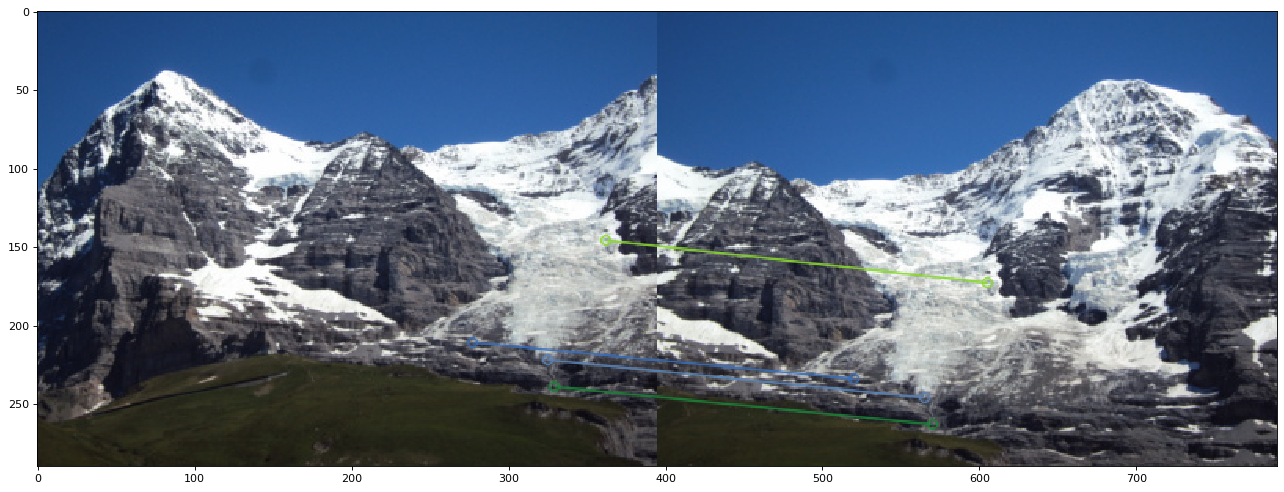

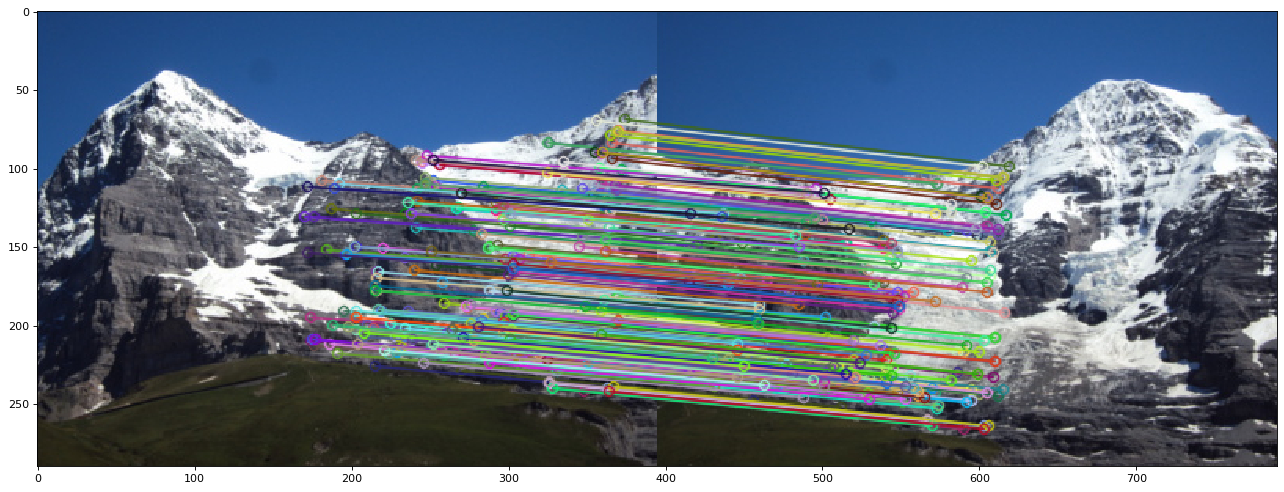

In [247]:
mask = np.array(inlier_ind, dtype=bool)

mfilter = []
for idx,i in enumerate(mask):
    if i == True:
        mfilter.append(dMatch[idx])
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
print(len(mfilter))
f=cv2.drawMatches(img1, kp1, img2, kp2, mfilter, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(20, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()
f=cv2.drawMatches(img1, kp1, img2, kp2, dMatch, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(20, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()

In [248]:
inlier_ind = inlier_ind.astype('bool')
print(x1[inlier_ind])
print(y1[inlier_ind])
# print(x2[inlier_ind])
# print(y2[inlier_ind])
print(inlier_ind)

[102 349 355 370]
[136 70 90 132]
[False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False

In [249]:
stk = np.vstack((x1[inlier_ind],y1[inlier_ind],np.ones(np.sum(inlier_ind))))
stk2 = np.vstack((x2[inlier_ind],y2[inlier_ind],np.ones(np.sum(inlier_ind))))
j = H@stk
j = j/j[-1]
print(j)
print(np.linalg.norm(j-stk2,axis=0))

[[240 351 42 30]
 [136 138 119 106]
 [1 1 1 1]]
[8.27e-12 7.54e-09 9.97e-09 3.3e-09]


In [250]:
inv = np.linalg.inv(H)
inv = inv/inv[-1,-1]
res=inv@stk2
print(res/res[-1:]-stk)

[[-1.36e-09 -9.36e-10 6.87e-09 1.61e-09]
 [-6.25e-10 -2.56e-09 1.94e-08 4.55e-09]
 [0 0 0 0]]


In [251]:
fig=plt.figure(figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)
plt.scatter(x, y)
plt.axis('off')

NameError: name 'img' is not defined

<Figure size 1280x960 with 0 Axes>

In [ ]:
d = feat_desc(gray,x,y)

In [ ]:
# x_,y_ = np.meshgrid(np.arange(img1.shape[1]),np.arange(img1.shape[0]))
# pts_set = np.vstack(([x_.flatten()],[y_.flatten()],np.ones(len(x_.flatten()))))
# print(pts_set)
# stk = H@pts_set
# inds = np.ravel_multi_index(stk.astype('int'),(img1.shape[1], img1.shape[0]))
# flat_img = img1.reshape((img1.shape[0]*img1.shape[1],3))
# res_img = flat_img[inds]
# res_img = res_img.reshape((im.shape[0],im.shape[1],3))
# plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))


In [ ]:
for i in d:
    print(i)

In [ ]:
x = [[4,5,6],[1,2,3]]
res=np.linalg.norm(x,axis=1)
res.argsort()
print(res.argsort())

In [ ]:
x[-1]

In [ ]:
print(H)
mask = np.array(inlier_ind, dtype=bool)
# print(mask)
# print(x1*mask)
# print(y1*mask)
stack = np.vstack((x1*mask,y1*mask,np.ones((x1.shape))))
res = H@stack
print("-1:",end=" ")
print(res/res[-1])
print("reg:",end=" ")
print(res[0]/res[2])

stack = np.vstack((x2*mask,y2*mask,np.ones((x1.shape))))
print(stack)

In [ ]:
#img.shape[1],img.shape[0]
x,y = np.meshgrid(np.arange(100),np.arange(50))
pts_set = np.vstack(([x.flatten()],[y.flatten()],np.ones(len(x.flatten()))))

In [ ]:
x1 = np.array([-1,-1,1,1,0,0,                     90,222,88])
y1 = np.array([1,-1,-1,1,0,1,                     12321,33,1])
x2 = np.array([0,-2**0.5,0,2**0.5,0,0.5*(2**0.5), 777,3,4])
y2 = np.array([2**0.5,0,-2**0.5,0,0,0.5*(2**0.5), 2,9,999])


In [ ]:
for i in range(100):
    H, inlier_ind=ransac_est_homography(x1,y1,x2,y2,0.5)


In [ ]:
print(inlier_ind)
print(H)

In [ ]:
# p1 = [(88,1),(-1,1),(1,1),(1,-1)]
# p2 = [(4,999),(0,2**0.5),(2**0.5,0),(2**0.5,-2**0.5)]
x1 = np.array([-1,-1,1,1,0,0,                     90,222,88])
y1 = np.array([1,-1,-1,1,0,1,                     12321,33,1])
x2 = np.array([0,-2**0.5,0,2**0.5,0,0.5*(2**0.5), 777,3,4])
y2 = np.array([2**0.5,0,-2**0.5,0,0,0.5*(2**0.5), 2,9,999])
# [8, 0, 3, 2]
pts=[0,5,3,8]
p1 = [(x1[pts[0]],y1[pts[0]]),(x1[pts[1]],y1[pts[1]]),(x1[pts[2]],y1[pts[2]]),(x1[pts[3]],y1[pts[3]])]
p2 = [(x2[pts[0]],y2[pts[0]]),(x2[pts[1]],y2[pts[1]]),(x2[pts[2]],y2[pts[2]]),(x2[pts[3]],y2[pts[3]])]
print(p2)
pointsTotal = len(p1)

A = np.zeros((8,9))
# Homography matrix
for i in range(4): # Using the corners
        A[i*2,:] = [ p1[i][1], p1[i][0], 1, 0, 0, 0, -p2[i][1]*p1[i][1], -p2[i][1]*p1[i][0], -p2[i][1] ]
        A[i*2+1,:] = [0, 0, 0, p1[i][1], p1[i][0], 1, -p2[i][0]*p1[i][1], -p2[i][0]*p1[i][0], -p2[i][0] ]


# Alternative (provide worse results)
#[V,W] = np.linalg.eig(np.dot(A.T,A))
#m = W[:,-1]

[U,S,V]=np.linalg.svd(A)
m = V[-1,:]/V[-1,-1]
print(m)
H = np.reshape(m,(3,3))
print(H.T)
# print(p2[2])
pt=3
v=H.T@np.append(p1[pt],1)
v=v/v[-1]
print(v[0:2]-p2[pt])
# It should be close to zero
print("This value should be close to zero: "+str(np.sum(np.matmul(A,m))))

In [ ]:
o=np.array([2.05e-18 6.52e-19 1.4e-18 1.57e-16 2.57e-16 -1.79e-16 1.55e-18 -1 1])

In [ ]:
print(img1[1203:1203+40,:])

In [ ]:
img = gray
padImage = np.zeros((img.shape[0]+40,img.shape[1]+40))
padImage[20:img.shape[0]+20,20:img.shape[1]+20] = img
# #first 20 rows
for i in range(20):
    for j in range(20,img.shape[1]+20):
        padImage[i,j] = padImage[i+20,j]
#first 20 columns
for i in range(20,img.shape[0]+20):
    for j in range(20):
        padImage[i,j] = padImage[i,j+20]
# last 20 rows
for i in range(img.shape[0]+20,img.shape[0]+40):
    for j in range(20,img.shape[1]+20):
        padImage[i,j] = padImage[i-20,j]
#last 20 cols
for i in range(20,img.shape[0]+20):
    for j in range(img.shape[1]+20,img.shape[1]+40):
        padImage[i,j] = padImage[i,j-20]
plt.imshow(padImage)